In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
AUDIO_PATH = "/content/drive/MyDrive/VoxCeleb_gender"

MAX_LEN = 40
SAMPLE_RATE = 22050
N_MFCC = 13

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T

    if mfcc.shape[0] < MAX_LEN:
        pad_width = MAX_LEN - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:MAX_LEN]
    return mfcc


In [ ]:
X, y = [], []

# Loop through folders and extract features
for label in os.listdir(AUDIO_PATH):
    folder = os.path.join(AUDIO_PATH, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                file_path = os.path.join(folder, file)
                try:
                    mfcc = extract_features(file_path)
                    X.append(mfcc)
                    y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

X = np.array(X)
y = np.array(y)

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = tf.keras.utils.to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Data loaded. Shape: {X.shape}, Labels: {le.classes_}")


Data loaded. Shape: (6013, 40, 13), Labels: ['females' 'males']


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = "/content/3350.wav"
y, sr = librosa.load(audio_file_path)

# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_file_path = "/content/drive/MyDrive/VoxCeleb_gender/males/1.wav"
y, sr = librosa.load(audio_file_path)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.tight_layout()
plt.show()


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN, N_MFCC)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6771 - loss: 0.5950 - val_accuracy: 0.7789 - val_loss: 0.4654
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7912 - loss: 0.4581 - val_accuracy: 0.7938 - val_loss: 0.4313
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8175 - loss: 0.4135 - val_accuracy: 0.8047 - val_loss: 0.4300
Epoch 4/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8496 - loss: 0.3628 - val_accuracy: 0.8387 - val_loss: 0.3715
Epoch 5/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8607 - loss: 0.3380 - val_accuracy: 0.8396 - val_loss: 0.3698
Epoch 6/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8589 - loss: 0.3419 - val_accuracy: 0.8470 - val_loss: 0.3633
Epoch 7/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8754 - loss: 0.3112 - val_accuracy: 0.8396 - val_loss: 0.3491
Epoch 8/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8778 - loss: 0.3045 - val_accuracy: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import librosa
import numpy as np

def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        mfccs = mfccs.T
        mfccs = mfccs[:40]
        if mfccs.shape[0] < 40:
            pad_width = 40 - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        return mfccs
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None


In [ ]:
!pip install librosa
!pip install resampy

In [ ]:
!pip install resampy

In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 40, 64)              │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,848 (671.29 KB)

 Trainable params: 57,282 (223.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 114,566 (447.53 KB)

In [ ]:
import os

folder = r"/content/drive/MyDrive/VoxCeleb_gender"
print(os.listdir(folder))

['males', 'females']


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
print(report)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

     females       0.85      0.78      0.81       455
       males       0.87      0.91      0.89       748

    accuracy                           0.86      1203
   macro avg       0.86      0.85      0.85      1203
weighted avg       0.86      0.86      0.86      1203



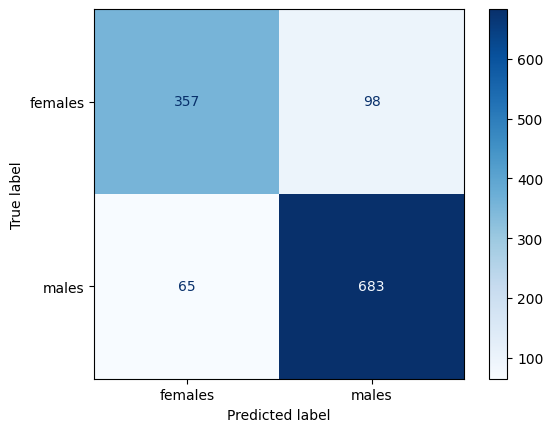

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
!pip install librosa resampy numpy


In [ ]:
!pip install librosa resampy numpy scikit-learn

In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from google.colab import files
import os

In [ ]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        if mfccs.shape[1] < 40:
            pad_width = 40 - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :40]
        return mfccs.T
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [ ]:
# Step 5: Prediction function
def predict_gender(audio_file_path):
    mfccs = extract_features(audio_file_path)
    if mfccs is not None:
        mfccs = np.expand_dims(mfccs, axis=0)  # Shape: (1, 40, 13)
        prediction = model.predict(mfccs)
        predicted_class = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_class])[0]
        return predicted_label
    else:
        return "Error extracting features."

Saving 3354.wav to 3354.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted gender for 3354.wav: males


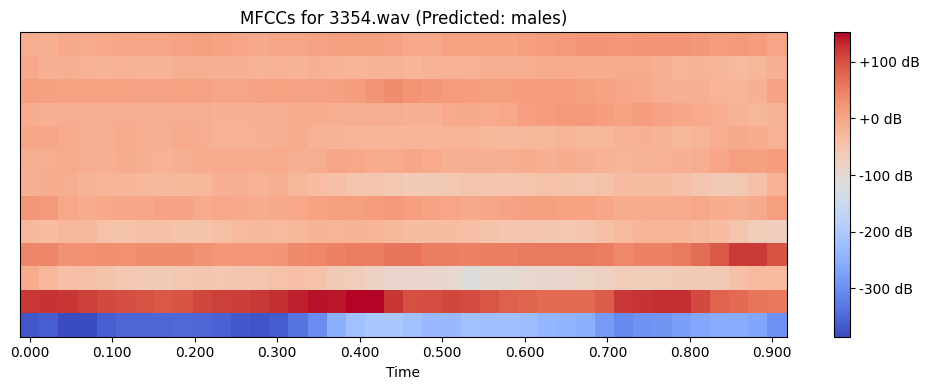

In [ ]:

import IPython.display as ipd
uploaded = files.upload()

for fn in uploaded.keys():
    audio_file_path = fn
    predicted_gender = predict_gender(audio_file_path)
    print(f"Predicted gender for {audio_file_path}: {predicted_gender}")

    mfccs = extract_features(audio_file_path)

    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs.T, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCCs for {audio_file_path} (Predicted: {predicted_gender})')
        plt.tight_layout()
        plt.show()

ipd.Audio(audio_file_path)


Saving 841.wav to 841 (2).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predicted gender for 841 (2).wav: females


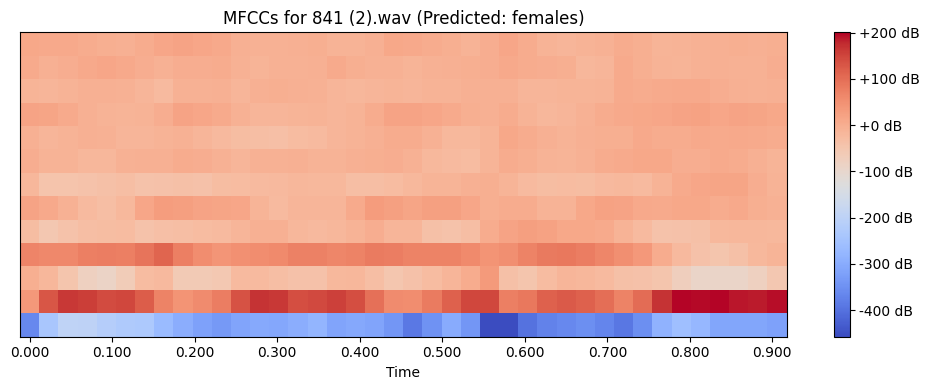

In [ ]:
import IPython.display as ipd
uploaded = files.upload()

for fn in uploaded.keys():
    audio_file_path = fn
    predicted_gender = predict_gender(audio_file_path)
    print(f"Predicted gender for {audio_file_path}: {predicted_gender}")

    mfccs = extract_features(audio_file_path)

    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs.T, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCCs for {audio_file_path} (Predicted: {predicted_gender})')
        plt.tight_layout()
        plt.show()

ipd.Audio(audio_file_path)
